In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import california_housing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

(inputs, targets), (x_test, y_test) = california_housing.load_data(version='small',
                                        test_split=0.2)
print(inputs.shape, targets.shape)
print(x_test.shape, y_test.shape)

(480, 8) (480,)
(120, 8) (120,)


### Jaetaan malli osiin

In [2]:
x_train = inputs[:380]
y_train = targets[:380]
x_val = inputs[380:]
y_val = targets[380:]

In [3]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std
x_val -= mean
x_val /= std
y_train /= 1e5
y_test /= 1e5
y_val /= 1e5

### Määritellään mallit

In [4]:

# Alkuperäinen
model1 = Sequential([
    Input(shape=(8,)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

history1 = model1.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), verbose=0)

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model2 = Sequential([
    Input(shape=(8,)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

history2 = model2.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), verbose=0,
                      callbacks=[early_stopping])

# Model 3: With L2 Regularization
model3 = Sequential([
    Input(shape=(8,)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])

model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

history3 = model3.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), verbose=0)

### Visuaalinen tarkistelu

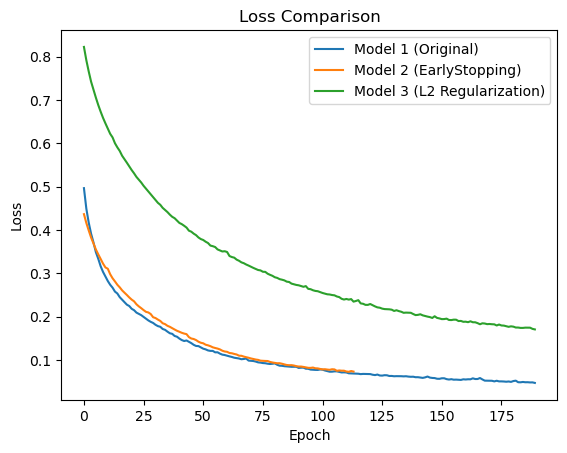

In [5]:
# Plot Loss Comparison
plt.plot(history1.history['loss'][10:], label='Model 1 (Original)')
plt.plot(history2.history['loss'][10:], label='Model 2 (EarlyStopping)')
plt.plot(history3.history['loss'][10:], label='Model 3 (L2 Regularization)')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.show()

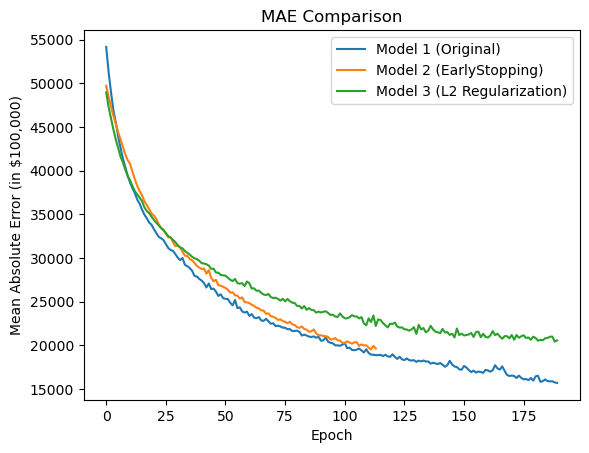

In [6]:
# Convert MAE back to original scale (in $100,000)
plt.plot(np.array(history1.history['mae'][10:]) * 1e5, label='Model 1 (Original)')
plt.plot(np.array(history2.history['mae'][10:]) * 1e5, label='Model 2 (EarlyStopping)')
plt.plot(np.array(history3.history['mae'][10:]) * 1e5, label='Model 3 (L2 Regularization)')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (in $100,000)')
plt.title('MAE Comparison')
plt.show()

### Tutkitaan testi vaiheen mallien tuloksia

In [7]:
test_loss1, test_mae1 = model1.evaluate(x_test, y_test)
test_loss2, test_mae2 = model2.evaluate(x_test, y_test)
test_loss3, test_mae3 = model3.evaluate(x_test, y_test)

print(f'Model 1 (Original) - Test MAE: {test_mae1:.4f}')
print(f'Model 2 (EarlyStopping) - Test MAE: {test_mae2:.4f}')
print(f'Model 3 (L2 Regularization) - Test MAE: {test_mae3:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3108 - mae: 0.3263 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3442 - mae: 0.3437 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3941 - mae: 0.2937 
Model 1 (Original) - Test MAE: 0.3148
Model 2 (EarlyStopping) - Test MAE: 0.3314
Model 3 (L2 Regularization) - Test MAE: 0.2903


### Koulutetaan paras malli kaikella

tässä tapauksessa Earlystopping malli

### EDIT: Windows koneella tehty ajo: Paras malli on l2 regularization malli

In [11]:
x_train_full = np.concatenate((x_train, x_val), axis=0) # join train + val sets
y_train_full = np.concatenate((y_train, y_val), axis=0)

history3 = model3.fit(x_train_full, y_train_full, epochs=200, batch_size=32, validation_data=(x_val, y_val), verbose=0,
                      callbacks=[early_stopping])

In [9]:
test_loss, test_mae = model2.evaluate(x_test, y_test)
print(f'Test mean average error: {test_mae:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3033 - mae: 0.3294 
Test mean average error: 0.3173


In [10]:
from tensorflow.keras.losses import MeanAbsoluteError

y_pred_baseline = np.full_like(y_test, np.mean(y_train_full, axis=0))
mae_fn = MeanAbsoluteError()
mae_baseline = mae_fn(y_test, y_pred_baseline).numpy()
print(f'Mean baseline MAE: {mae_baseline:.4f}')

Mean baseline MAE: 0.8367


### Johtopäätös

En päässyt tavoitteeseen (0,30). Lähin tulos, minkä sain oli noin 0,35. Macbookilla,

Windows koneella sain tulokseksi 0,32. Mitä ihmettä....
